### Import Packages

In [18]:
import math
import heapq
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

warnings.filterwarnings('ignore')

### Read in Data

In [19]:
# read in csv as dataframe
raw_df = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True, index_col=0)
stocks = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
data = raw_df[stocks]
data.ffill()

def train_test_split(df, ratio = 0.5):
    n = len(df)
    split = math.floor(n * ratio)
    
    return df[:split], df[split:]

# split into train and test set
train, test = train_test_split(data, 0.8)

In [20]:
train

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67
...,...,...,...,...,...
2016-10-11,116.300000,57.190,37.27,831.00,169.04
2016-10-12,117.340000,57.110,37.13,834.09,169.30
2016-10-13,116.980000,56.920,36.97,829.28,167.42


#### 1. Visualisation & Exploration

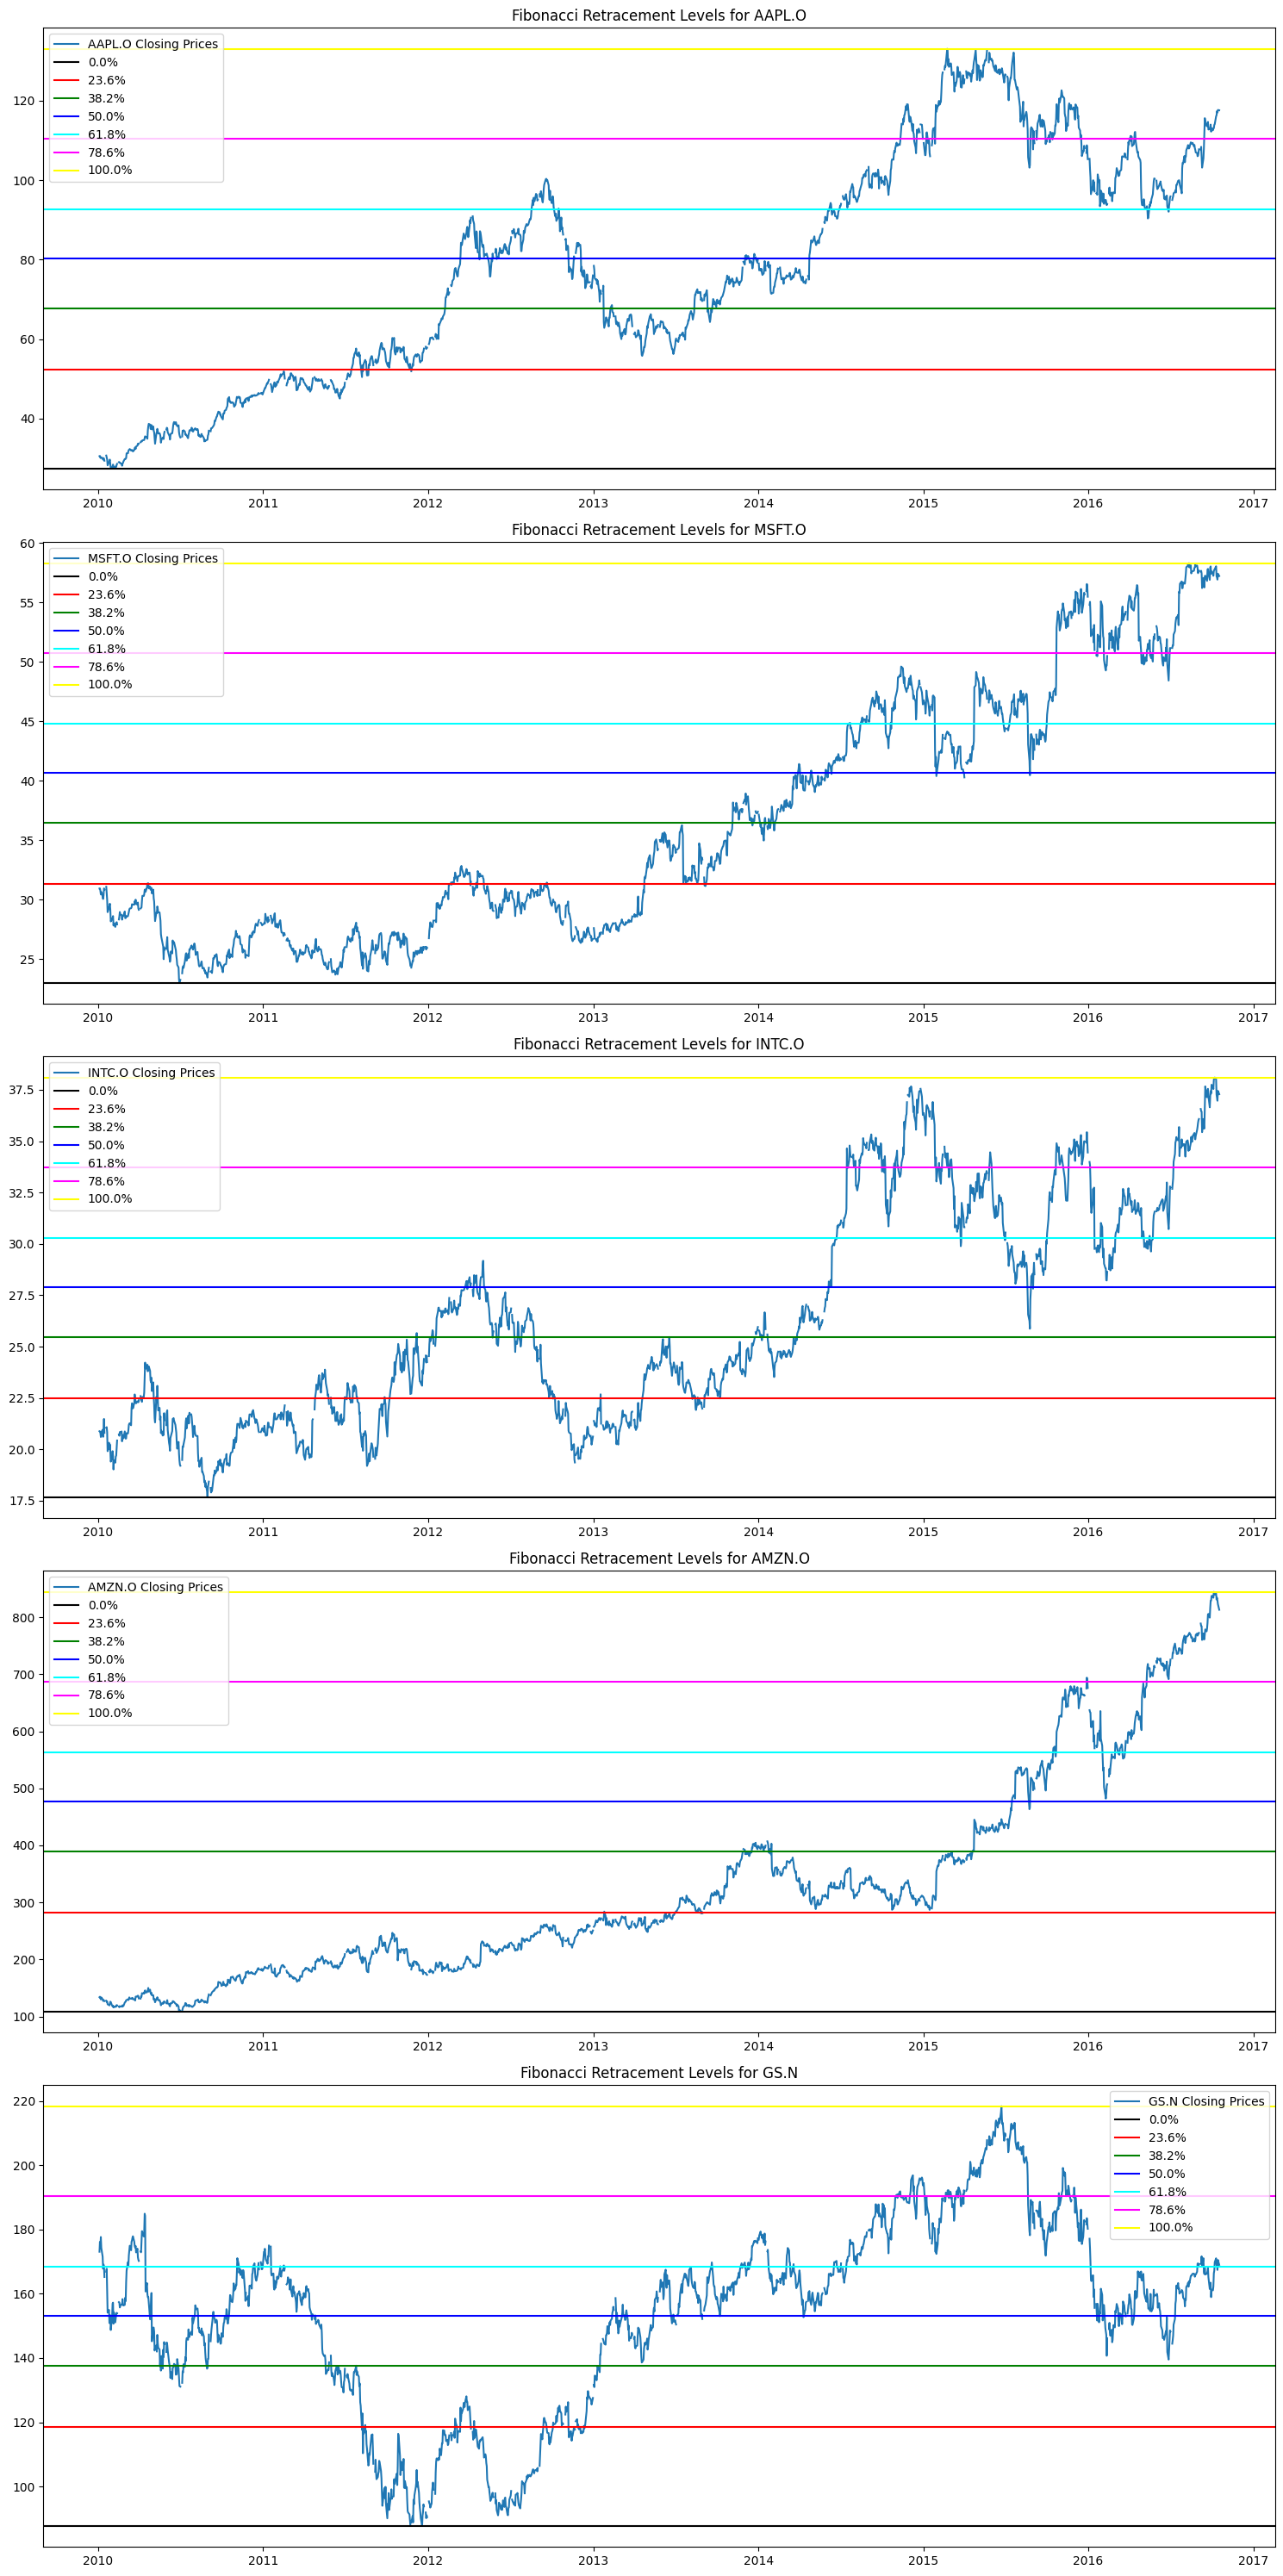

'\n Using a simple range from lowest to highest stock price and drawing the fib levels from this range, \n we can see that for these stocks, the fib levels show that they can be used as an indicator of support and resistance levels.\n We will explore different fib ranges and strategy later in the code.\n'

In [21]:
# dict to store fib ranges for training set
fib_ranges = {}
ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786,1]
colors = ["black","r","g","b","cyan","magenta","yellow"]
for stock in stocks:

    levels = []
    max_level = train[stock].max()
    min_level = train[stock].min()
    for ratio in ratios:
        levels.append(min_level + (max_level-min_level)*ratio)
    fib_ranges[stock] = levels
       
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i, stock in enumerate(stocks):  # Iterate through each stock with its index
    axes[i].plot(train.index, train[stock], label=f'{stock} Closing Prices')  # Plot the closing prices for each stock
    axes[i].set_title(f'Fibonacci Retracement Levels for {stock}')
    
    for j, level in enumerate(fib_ranges[stock]):
        # Correctly call axhlines on each subplot axis object
        axes[i].axhline(level, label="{:.1f}%".format(ratios[j]*100), color=colors[j], linestyle="-")

    axes[i].legend()

plt.tight_layout()
plt.show()

'''
 Using a simple range from lowest to highest stock price and drawing the fib levels from this range, 
 we can see that for these stocks, the fib levels show that they can be used as an indicator of support and resistance levels.
 We will explore different fib ranges and strategy later in the code.
'''

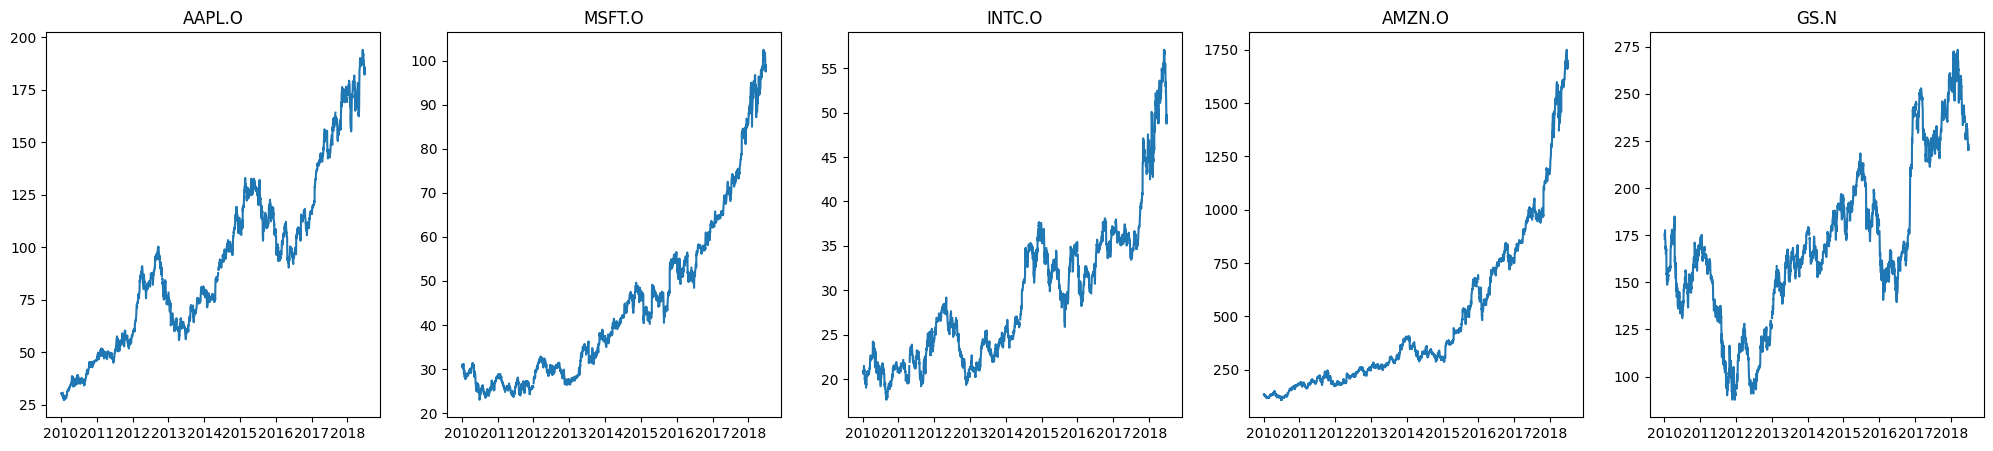

In [22]:
# Visualising general trend of our basket of stocks
_, axes = plt.subplots(1, 5, figsize=(25,5))
for index, stock in enumerate(stocks):
    axes[index].plot(data[stock])
    axes[index].set_title(stock)

#### 2. Strategy Creation

In [23]:
def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

def fibonacci_retracement(stock, window, exit_level):
    levels = ['level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7']
    stock = pd.DataFrame({"close": stock.copy().ffill()})
    stock["lag_1"] = stock.close.shift(1)
    
    stock["rolling_max"] = stock["close"].rolling(window).max().ffill()
    stock["rolling_min"] = stock["close"].rolling(window).min().ffill()
    
    result_array = stock.apply(lambda row: calculate_fib_levels(row["rolling_max"], row["rolling_min"]), axis=1)
    result_df = pd.DataFrame(result_array.tolist(), columns=levels).set_index(stock.index)
    stock = pd.concat([stock, result_df], axis=1)
    
    # Get entry
    temp_stock = stock.copy()
    name_crossups = ["level_1_crossup", "level_2_crossup", "level_3_crossup", "level_4_crossup", "level_5_crossup", "level_6_crossup", "level_7_crossup"]
    for index, level in enumerate(levels):
        signal_buy = (temp_stock.lag_1 < temp_stock[level]) & (temp_stock.close > temp_stock[level])
        temp_stock.loc[signal_buy, name_crossups[index]] = temp_stock[level]

    # Process exit
    heap = []
    stock["position"] = 0
    stock['pnl'] = 0
    for index, row in temp_stock.iterrows():
        entry_signal_price = row[name_crossups].min()
        
        
        # Sell if current price exceeds target exit price, starting from lowest target exit price
        while len(heap) > 0 and row.close >= heap[0][0]:
            target_exit_price, target_index = heapq.heappop(heap)
            stock.loc[target_index, "exit_index"] = index
            stock.loc[target_index, "exit_price"] = row.close
            stock.loc[index, "pnl"] += row.close - stock.loc[target_index, "entry_price"]
            stock.loc[index, "position"] -= 1
        
        # Has a buy position
        if entry_signal_price > 0:
            target_level_prices = list(filter(lambda x: x > entry_signal_price, row[levels]))
            target_exit_price = target_level_prices[min(exit_level - 1, len(target_level_prices) - 1)]
            heapq.heappush(heap, (target_exit_price, index))
            stock.loc[index, "entry_price"] = entry_signal_price
            stock.loc[index, "position"] += 1
            
            
    # Close remaining open positions at the end of the period
    while len(heap) > 0:
        target_exit_price, target_index = heapq.heappop(heap)
        stock.loc[target_index, "exit_index"] = index
        stock.loc[target_index, "exit_price"] = stock.close[-1]
        stock.loc[target_index, "pnl"] += stock.close[-1] - target_exit_price
        stock.loc[index, "position"] -= 1

    # Calculate average position price
    prev_avg_cost = 0
    prev_position = 0
    stock["avg_cost"] = 0
    acc_position = 0
    for row in stock[["entry_price", "position"]].iterrows():
        index, items = row
        position = items["position"]
        entry_price = items["entry_price"]
        acc_position += position
        
        if acc_position > prev_position:
            prev_avg_cost = ((prev_position * prev_avg_cost) + (position * entry_price)) / acc_position
            prev_position = acc_position
            stock.loc[index, "avg_cost"] = prev_avg_cost
        elif acc_position < prev_position:
            prev_position = acc_position
            stock.loc[index, "avg_cost"] = prev_avg_cost
        elif acc_position == 0:
            prev_avg_cost = 0
            prev_position = 0
    
    return stock

    

#### 3. Strategy Visualisation

In this section, we will analyse the raw performance of our strategy with default settings. 

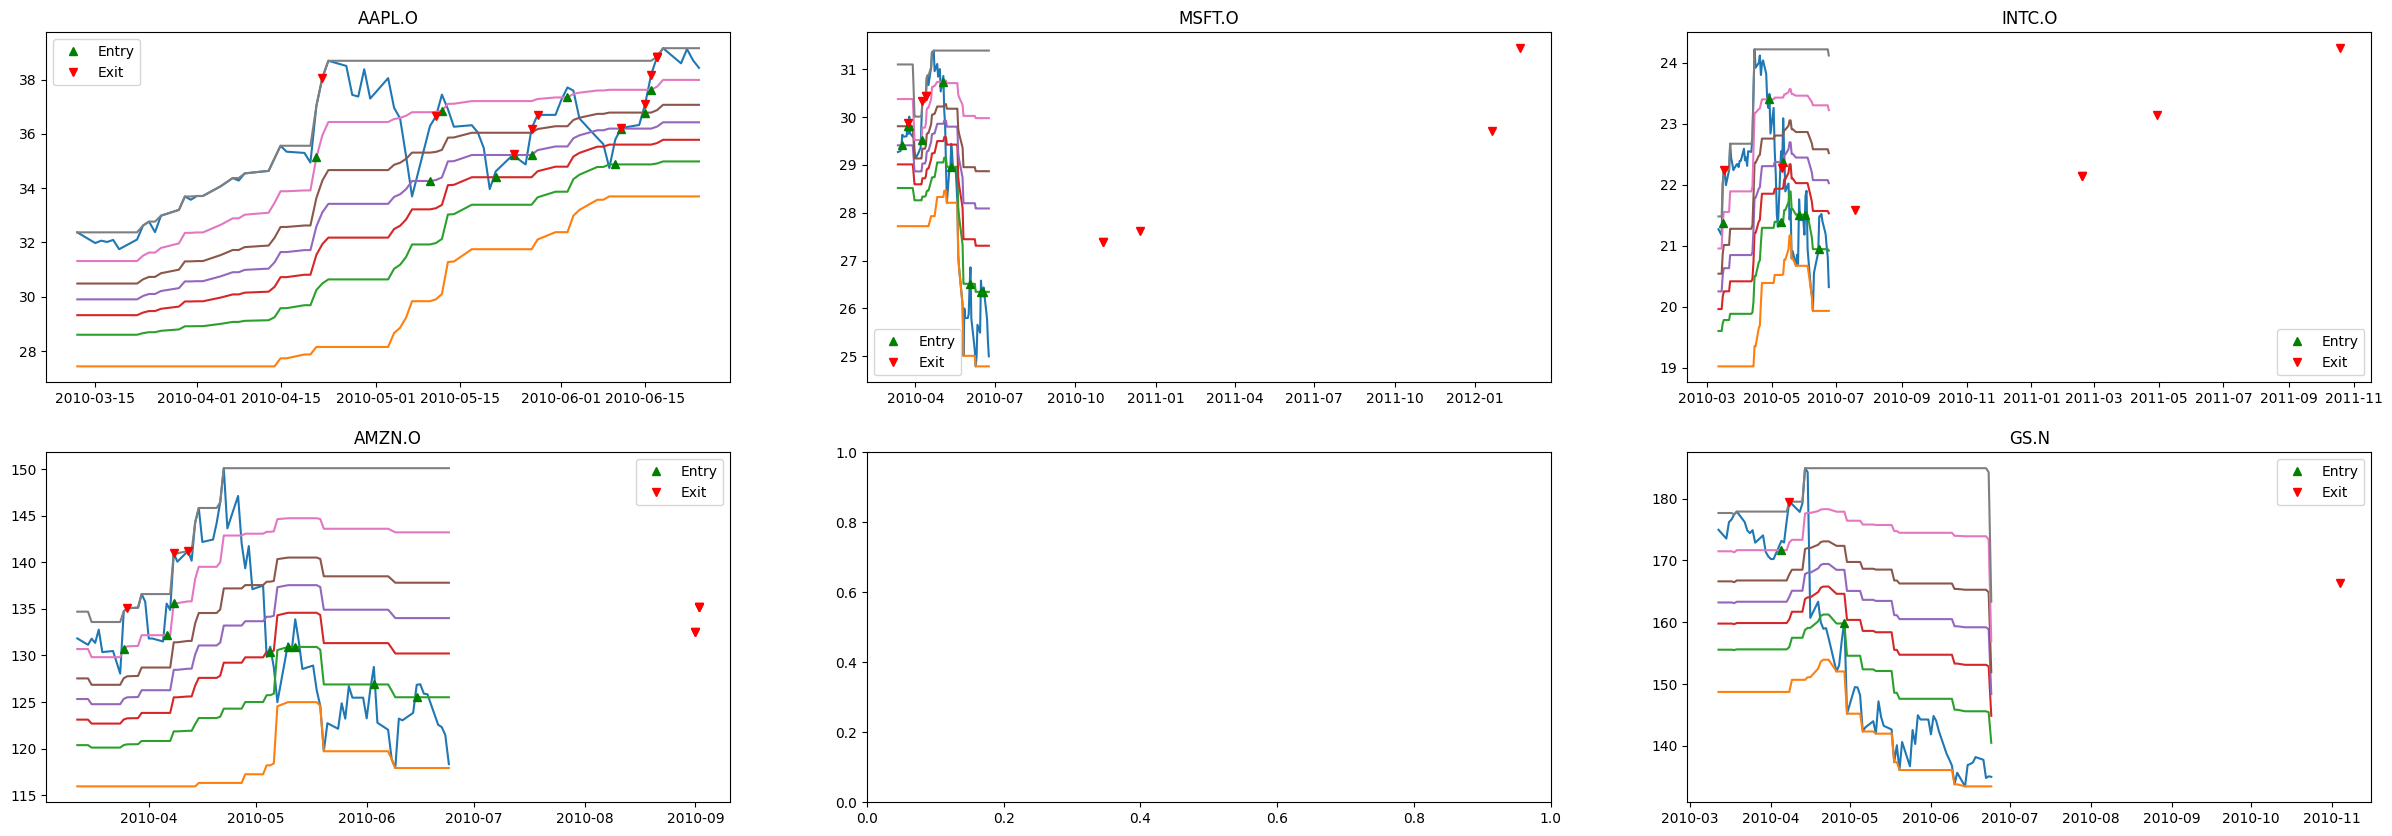

In [24]:
exit_level = 1 # The level step for the order to exit
window_lookback = 50
win_obsrv_start, win_obsrv_end = 50, 125

_, ax = plt.subplots(2, 3, figsize=(30, 10))
ax1, ax2, ax3 = ax[0]
ax4, ax5, ax6 = ax[1]
axes = [ax1, ax2, ax3, ax4, ax6]

def plot(name, df, ax):
    ax.plot(df.close)
    ax.plot(df.level_1)
    ax.plot(df.level_2)
    ax.plot(df.level_3)
    ax.plot(df.level_4)
    ax.plot(df.level_5)
    ax.plot(df.level_6)
    ax.plot(df.level_7)
    ax.plot(df.entry_price, "g^", label="Entry")
    ax.plot(df.exit_index, df.exit_price, "rv", label="Exit")
    ax.set_title(name)
    ax.legend()
    
for index, stock in enumerate(stocks):
    result_fib_retrace = fibonacci_retracement(train[stock], window_lookback, exit_level)
    plot(stock, result_fib_retrace[win_obsrv_start: win_obsrv_end], axes[index])

plt.show() # Show different entry and exit points at the fib levels calculated using a rolling basis.

#### 4. Strategy Performance Evaluation

In [60]:
def plot_pnl(df):
    return df.pnl.cumsum().ffill()[-1]
    
def cal_total_pnl(df):
    hasPosition = df.avg_cost > 0
    unrealised = df.close[hasPosition] - df.avg_cost[hasPosition]
    realised = df.pnl.cumsum().ffill()
    total_pnl = realised + unrealised
    return total_pnl
    
def cal_max_drawdown(df):
    df = df[df > 0]
    adj_max = df.cummax() 
    adj_df = df 
    return ((adj_df - adj_max) / adj_max).min() * 100

def cal_sharpe_ratio(df):
    return df.mean() / df.std()

def print_performance_metrics(df_result):
    total_pnl = cal_total_pnl(df_result)
    number_of_trades = df_result.entry_price.count()
    max_drawdown = cal_max_drawdown(total_pnl.ffill())
    sharpe_ratio = cal_sharpe_ratio(total_pnl)
    # market pnl equivalent to holding 1 share all the way
    market_pnl = df_result.close.diff().cumsum().ffill()[-1]
    market_drawdown = cal_max_drawdown(df_result.close.diff().cumsum().ffill())
    print(f"{stock}\nTotal PnL: {total_pnl.ffill()[-1]}\nNumber of Trades: {number_of_trades}\nMax Drawdown: {max_drawdown}%  \nSharpe Ratio {sharpe_ratio}\nMarket PnL: {market_pnl}\nMarket Drawdown: {market_drawdown}%\n")

for index, stock in enumerate(stocks):
    result_fib_retrace = fibonacci_retracement(train[stock], window_lookback, exit_level)
    print("Train")
    print_performance_metrics(result_fib_retrace)
    
    print("Test")
    result_fib_retrace = fibonacci_retracement(test[stock], window_lookback, exit_level)
    print_performance_metrics(result_fib_retrace)

Train
AAPL.O
Total PnL: 1086.4502227861074
Number of Trades: 624
Max Drawdown: -79.52549342771285%  
Sharpe Ratio 1.3935605485806664
Market PnL: 86.97717343
Market Drawdown: -63.834538712122765%

Test
AAPL.O
Total PnL: 446.5067600000003
Number of Trades: 156
Max Drawdown: -11.89846466341996%  
Sharpe Ratio 1.3888359933663013
Market PnL: 67.64000000000001
Market Drawdown: -43.58974358974396%

Train
MSFT.O
Total PnL: 466.9863049625004
Number of Trades: 598
Max Drawdown: -60.85490225297793%  
Sharpe Ratio 1.4266217000618384
Market PnL: 26.27
Market Drawdown: -98.68421052631568%

Test
MSFT.O
Total PnL: 205.34873749999997
Number of Trades: 161
Max Drawdown: -49.478559682345455%  
Sharpe Ratio 1.4092059188601893
Market PnL: 40.95
Market Drawdown: -86.22754491017963%

Train
INTC.O
Total PnL: 361.71622780000047
Number of Trades: 620
Max Drawdown: -75.6886432763568%  
Sharpe Ratio 1.6584299705407957
Market PnL: 16.41
Market Drawdown: -99.70068841664168%

Test
INTC.O
Total PnL: 108.8314099999998

#### 5. Strategy Optimisation

In [61]:
# Objective function to maximise PNL 
def fitness(df, window_lookback, exit_level):
    result_fib_retrace = fibonacci_retracement(df, window_lookback, exit_level)
    total_pnl = cal_total_pnl(result_fib_retrace)

    return total_pnl.ffill()[-1]

# Define the genetic algorithm
def genetic_algorithm(df, params_constraint, population_n=1, generations_n = 10, include_genome=[]):
    # Initialize the population with random values within the parameter range, each individual represented by a dict
    population = [{'window_lookback': random.randint(params_constraint['window_lookback'][0], params_constraint['window_lookback'][1]),
                   'exit_level': random.randint(params_constraint['exit_level'][0], params_constraint['exit_level'][1])}
                  for _ in range(population_n)]
    population += include_genome

    # Evolution loop
    for _ in range(generations_n):
        # Evaluate the fitness of each individual in the population
        fitness_scores = [(individual, fitness(df, individual['window_lookback'], individual['exit_level'])) for individual in population]

        # Sort the population by fitness score
        fitness_scores.sort(key=lambda x: x[1], reverse=True)

        # Select the top individuals to be parents for the next generation
        parents = [individual[0] for individual in fitness_scores[:population_n // 2]]
        # Create the next generation by crossover and mutation
        next_generation = parents
        while len(next_generation) < population_n:
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)

            # Crossover
            child = {'window_lookback': (parent1['window_lookback'] + parent2['window_lookback']) // 2,
                     'exit_level': (parent1['exit_level'] + parent2['exit_level']) // 2}

            # Mutation
            val = random.random()
            if val <= 0.1:
                child['window_lookback'] = random.randint(params_constraint['window_lookback'][0], params_constraint['window_lookback'][1])
            val = random.random()
            if val <= 0.1:
                child['exit_level'] = random.randint(params_constraint['exit_level'][0], params_constraint['exit_level'][1])

            # Ensure parameters are within range
            child['window_lookback'] = min(max(params_constraint['window_lookback'][0], child['window_lookback']), params_constraint['window_lookback'][1])
            child['exit_level'] = min(max(params_constraint['exit_level'][0], child['exit_level']), params_constraint['exit_level'][1])

            next_generation.append(child)

        population = next_generation

    # Return the best individual
    return population[0]

# Break the dataset into different windows, and use the optimal parameters for one window into the next, until the end
def walk_forward_optimisation(data, params_constraint, windows_n=5, train_test_ratio = 0.5, population_n=10):
    n = len(data)
    window_size = n // windows_n
    
    include_genome = []
    optimized_params = []
    for i in range(windows_n):
        train, test = train_test_split(data[:i + window_size], train_test_ratio)
        optimized_params = genetic_algorithm(train.copy(), params_constraint=params_constraint, population_n=population_n, include_genome=include_genome)
        include_genome = [optimized_params]
    
    return optimized_params

#### 6. Results with Optimisation

============ AAPL.O ============
Train optimised
AAPL.O
Total PnL: 1121.967716218975
Number of Trades: 624
Max Drawdown: -79.52549342771285%  
Sharpe Ratio 1.3892580381643365
Market PnL: 86.97717343
Market Drawdown: -63.834538712122765%

Test Results
AAPL.O
Total PnL: 482.5216400000005
Number of Trades: 156
Max Drawdown: -78.79581151832433%  
Sharpe Ratio 1.3414308396031436
Market PnL: 67.64000000000001
Market Drawdown: -43.58974358974396%

Best Parameters
Window Lookback: 5 
Exit Level: 6



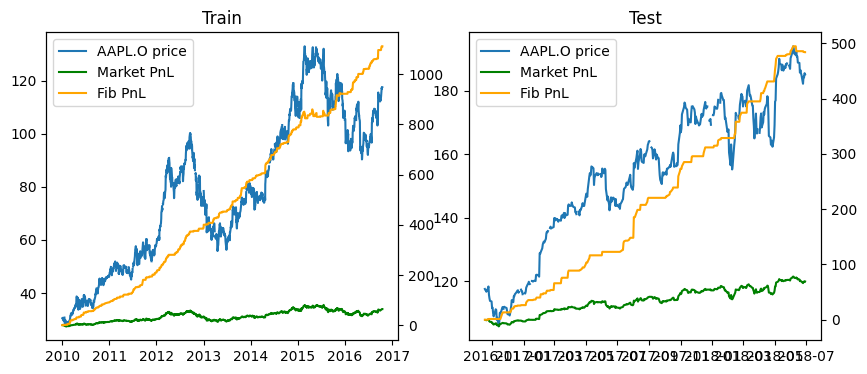

============ MSFT.O ============
Train optimised
MSFT.O
Total PnL: 522.4087007081631
Number of Trades: 571
Max Drawdown: -79.21147007527391%  
Sharpe Ratio 1.451607659232376
Market PnL: 26.27
Market Drawdown: -98.68421052631568%

Test Results
MSFT.O
Total PnL: 215.87912
Number of Trades: 150
Max Drawdown: -42.79732240276019%  
Sharpe Ratio 1.3567116471959817
Market PnL: 40.95
Market Drawdown: -86.22754491017963%

Best Parameters
Window Lookback: 6 
Exit Level: 6



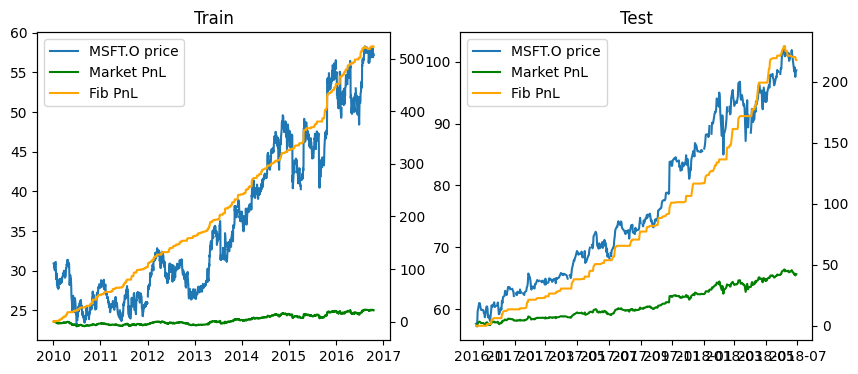

============ INTC.O ============
Train optimised
INTC.O
Total PnL: 410.9562134000001
Number of Trades: 537
Max Drawdown: -89.35488738640043%  
Sharpe Ratio 1.6065984199182648
Market PnL: 16.41
Market Drawdown: -99.70068841664168%

Test Results
INTC.O
Total PnL: 110.0661366666667
Number of Trades: 125
Max Drawdown: -48.469283450884035%  
Sharpe Ratio 1.2795741155413598
Market PnL: 11.96
Market Drawdown: -65.2173913043481%

Best Parameters
Window Lookback: 8 
Exit Level: 6



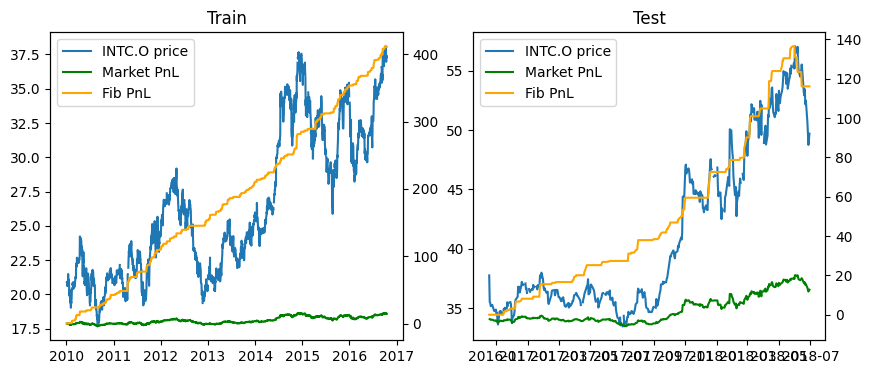

============ AMZN.O ============
Train optimised
AMZN.O
Total PnL: 6554.1320700000015
Number of Trades: 593
Max Drawdown: -12.359272020731545%  
Sharpe Ratio 1.3332068356658653
Market PnL: 679.0500000000001
Market Drawdown: -91.90858554663372%

Test Results
AMZN.O
Total PnL: 4079.3787750000047
Number of Trades: 166
Max Drawdown: -61.729501510546136%  
Sharpe Ratio 1.3255506885269475
Market PnL: 882.15
Market Drawdown: -98.8747553816046%

Best Parameters
Window Lookback: 6 
Exit Level: 6



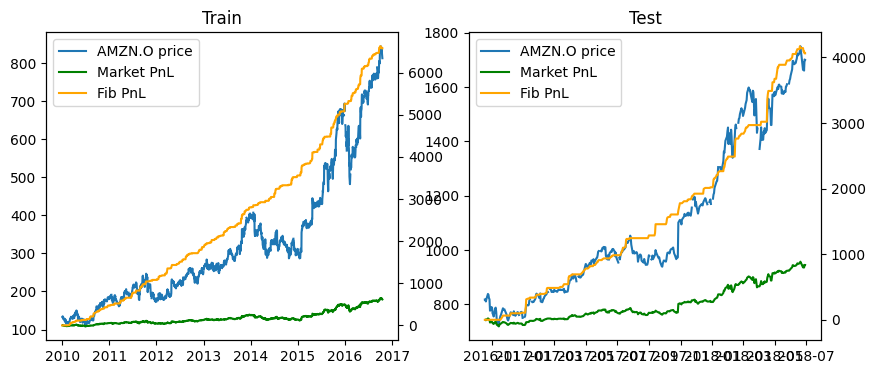

============ GS.N ============
Train optimised
GS.N
Total PnL: 1681.8724653922004
Number of Trades: 626
Max Drawdown: -21.542063210519252%  
Sharpe Ratio 2.0053533237749446
Market PnL: -4.0800000000000125
Market Drawdown: -98.9864864864867%

Test Results
GS.N
Total PnL: 513.1556657938715
Number of Trades: 160
Max Drawdown: -31.48673337734134%  
Sharpe Ratio 2.0100160091705894
Market PnL: 47.94
Market Drawdown: -52.803970223325045%

Best Parameters
Window Lookback: 5 
Exit Level: 4



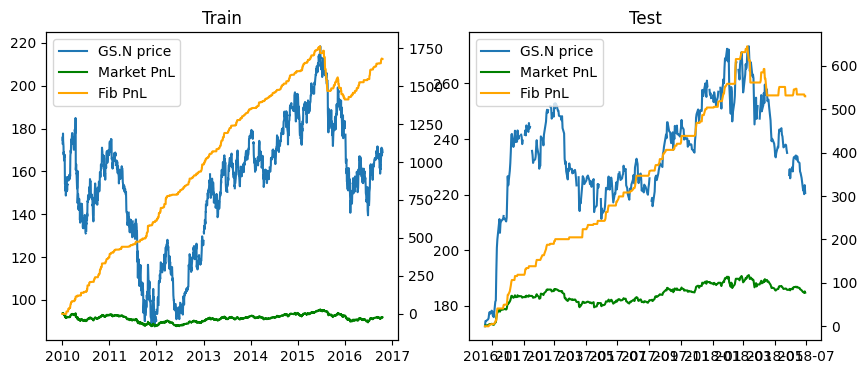

In [62]:
params_constraint = {
    "window_lookback": (5, 20),
    "exit_level": (0, 7)
}

# For each stock, using training data to apply optimisation and plot the results for both the train and test set
for index, stock in enumerate(stocks):
    print("============", stock, "============")
    _, axes = plt.subplots(1, 2, figsize=(10,4))
    ax1, ax2 = axes

    optimised_params = walk_forward_optimisation(train[stock].copy(), params_constraint=params_constraint, train_test_ratio=0.8, population_n=10)
    window_lookback, exit_level = optimised_params["window_lookback"], optimised_params["exit_level"]

    print("Train optimised")
    result = fibonacci_retracement(train[stock], window_lookback, exit_level)
    print_performance_metrics(result)
    
    # Plotting
    ax1.plot(train[stock], label=f"{stock} price")
    ax1_twin = ax1.twinx()
    ax1_twin.plot(train[stock].index, train[stock].diff().cumsum().ffill(), color="green", label="Market PnL") # Plot Pnl
    ax1_twin.plot(train[stock].index, result.pnl.cumsum().ffill(), color="orange", label="Fib PnL") # Plot Pnl
    ax1.set_title("Train")
    
    print("Test Results")
    result = fibonacci_retracement(test[stock], window_lookback, exit_level)
    print_performance_metrics(result)
    
    ax2.plot(test[stock], label=f"{stock} price")
    ax2_twin = ax2.twinx()
    ax2_twin.plot(test[stock].index, test[stock].diff().cumsum().ffill(), color="green", label="Market PnL") # Plot Pnl
    ax2_twin.plot(test[stock].index, result.pnl.cumsum().ffill(), color="orange", label="Fib PnL") # Plot Pnl
    ax2.set_title("Test")
    print(f"Best Parameters\nWindow Lookback: {window_lookback} \nExit Level: {exit_level}\n")

    # Get the handles and labels for each set of axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles1_twin, labels1_twin = ax1_twin.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles2_twin, labels2_twin = ax2_twin.get_legend_handles_labels()

    # Create a single legend for each subplot
    ax1.legend(handles1 + handles1_twin, labels1 + labels1_twin, loc='upper left')
    ax2.legend(handles2 + handles2_twin, labels2 + labels2_twin, loc='upper left')

    plt.show()
